<a href="https://colab.research.google.com/github/machadoulsenheimer/Solvers/blob/main/TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dwave-ocean-sdk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.7/18.7 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 352.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.8/223.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 4.6 MB/s eta 0:00:00


In [26]:
# Import necessary libraries
import numpy as np
from dwave.system import LeapHybridSampler
import dimod
from google.colab import userdata

# Define the penalty weights for constraints
A = 1  # Large number to enforce the "only one assignment per drone" constraint
B = 1  # Large number to enforce the "all drones must be assigned" constraint

# Sample input data (to be replaced with actual data)
num_drones = 5
num_belugas = 3

# Drone status: [Battery, Chemical Storage, Task Assigned]
drones = np.array([
    [80, 50, 1],
    [60, 30, 1],
    [40, 20, 0],
    [50, 10, 0],
    [90, 70, 1]
])

# Beluga station coordinates
belugas = np.array([
    [0, 0],
    [10, 10],
    [20, 0]
])

# Beluga priority levels (higher number indicates higher priority)
beluga_priorities = np.array([3, 5, 1])

# Distance matrix between drones and belugas
def create_distance_matrix(drone_positions, belugas):
    distance_matrix = np.zeros((num_drones, num_belugas))
    for i in range(num_drones):
        for j in range(num_belugas):
            distance_matrix[i, j] = np.linalg.norm(drone_positions[i] - belugas[j])
    return distance_matrix

# Sample drone positions
drone_positions = np.array([
    [1, 1],
    [2, 1],
    [3, 5],
    [2, 5],
    [5, 3]
])

distance_matrix = create_distance_matrix(drone_positions, belugas)

# Create the QUBO dictionary
qubo = {}

# Add objective: Minimize distance weighted by priority and maximize chemical storage
for i in range(num_drones):
    for j in range(num_belugas):
        # Objective: Minimize distance, maximize chemical storage
        qubo[(i, j)] = distance_matrix[i, j] / beluga_priorities[j] - drones[i, 1]

# Ensure each drone is assigned to only one Beluga
for i in range(num_drones):
    for j1 in range(num_belugas):
        for j2 in range(j1 + 1, num_belugas):
            qubo[((i, j1), (i, j2))] = A  # penalty for multiple assignments

# Ensure all drones are assigned
for i in range(num_drones):
    qubo[(i, 'assigned')] = B  # penalty if not assigned to any Beluga

# Convert the QUBO to a Binary Quadratic Model
bqm = dimod.BinaryQuadraticModel.from_qubo(qubo)

# Use LeapHybridSampler for optimization
sampler = LeapHybridSampler(token=userdata.get('DWAVE_TOKEN'))
sampleset = sampler.sample(bqm)

# Extract the best sample and its energy
best_sample = sampleset.first.sample
best_energy = sampleset.first.energy

print("Optimized Assignments:", best_sample)
print("Optimized Energy:", best_energy)

Optimized Assignments: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, (0, 0): 0, (0, 1): 1, (0, 2): 0, (1, 0): 0, (1, 1): 0, (1, 2): 1, (2, 0): 1, (2, 1): 0, (2, 2): 0, (3, 0): 1, (3, 1): 0, (3, 2): 0, (4, 0): 1, (4, 1): 0, (4, 2): 0, 'assigned': 0}
Optimized Energy: -434.0665542790314


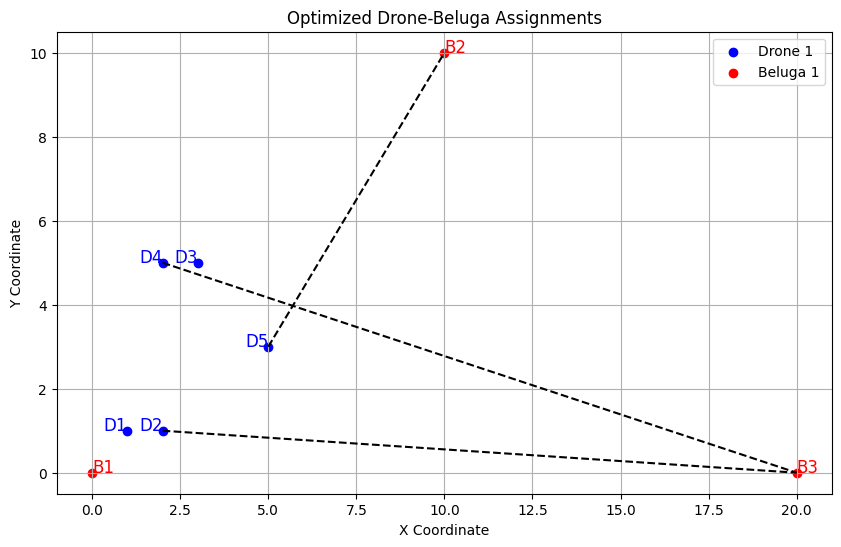

Drone to Beluga Assignments:
Drone 2 is assigned to Beluga 3.
Drone 4 is assigned to Beluga 3.
Drone 5 is assigned to Beluga 2.

Beluga to Drone Assignments:
Beluga 1 has the following drones assigned: None.
Beluga 2 has the following drones assigned: Drone 5.
Beluga 3 has the following drones assigned: Drone 2, Drone 4.



In [25]:
# Visualize the optimized solution based on given result
def visualize_solution(drone_positions, belugas, assignments):
    plt.figure(figsize=(10, 6))

    # Plot drone positions
    for i, pos in enumerate(drone_positions):
        plt.scatter(pos[0], pos[1], c='blue', label=f'Drone {i+1}' if i == 0 else "")
        plt.text(pos[0], pos[1], f'D{i+1}', fontsize=12, ha='right', color='blue')

    # Plot beluga positions
    for i, pos in enumerate(belugas):
        plt.scatter(pos[0], pos[1], c='red', label=f'Beluga {i+1}' if i == 0 else "")
        plt.text(pos[0], pos[1], f'B{i+1}', fontsize=12, ha='left', color='red')

    # Plot assignments
    for (key, assigned) in assignments.items():
        if isinstance(key, tuple) and assigned:
            drone, beluga = key
            drone_pos = drone_positions[drone]
            beluga_pos = belugas[beluga]
            plt.plot([drone_pos[0], beluga_pos[0]], [drone_pos[1], beluga_pos[1]], 'k--')

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Optimized Drone-Beluga Assignments')
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_solution(drone_positions, belugas, result)

# Correcting the way assignments are parsed
drone_assignments = {}
for key, value in result.items():
    if isinstance(key, tuple) and value == 1:
        drone, beluga = key
        drone_assignments[drone] = beluga

# Preparing text output
drone_to_beluga = {}
beluga_to_drones = {i: [] for i in range(num_belugas)}

# Formatting assignments
for drone, beluga in drone_assignments.items():
    drone_to_beluga[drone] = beluga
    beluga_to_drones[beluga].append(drone)

# Creating the text output
assignments_text = "Drone to Beluga Assignments:\n"
for drone, beluga in drone_to_beluga.items():
    assignments_text += f"Drone {drone + 1} is assigned to Beluga {beluga + 1}.\n"

assignments_text += "\nBeluga to Drone Assignments:\n"
for beluga, drones in beluga_to_drones.items():
    drones_text = ", ".join(f"Drone {d + 1}" for d in drones)
    assignments_text += f"Beluga {beluga + 1} has the following drones assigned: {drones_text if drones else 'None'}.\n"

print(assignments_text)